In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

import sys
# nbins = int(sys.argv[1])
nbins = 100

# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_%.5f_zmax_%.5f_quad_nbins_%d.npy'%(zmin, zmax, nbins)
print(oup_fname)

/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_3.50000_zmax_8.10000_quad_nbins_100.npy


In [2]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

In [3]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_Kkappa = get_f_Kkappa()

In [4]:
_KI = np.array(KI)

In [5]:
from interpax import interp2d, interp1d
import jax.numpy as jnp
from jax import jit

In [6]:
inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
inner_dkparp_integral = inner_dkparp_integral.astype(np.float64)

from scipy.interpolate import interp1d, interp2d, LinearNDInterpolator

tmp_chibs = []
tmp_log_deltas = []
tmp_fnctn = []
for i in range(len(chibs)):
    for j in range(len(deltas)):
        tmp_chibs += [chibs[i]]
        tmp_log_deltas += [np.log(deltas[j])]
        tmp_fnctn += [inner_dkparp_integral[:,i,j]]
        
f_inner_integral = LinearNDInterpolator(list(zip(tmp_chibs, tmp_log_deltas)), tmp_fnctn)

In [8]:
import matplotlib.pyplot as plt

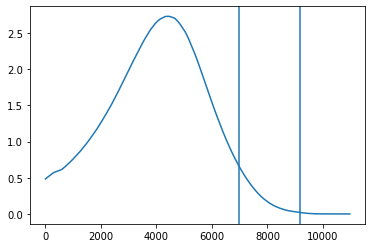

In [9]:
plt.plot(chis, _KI)
plt.axvline(chimin)
plt.axvline(chimax)

In [10]:
def integrand(chib, chi, ell_idx):
    _delta = np.abs(1 - chi / chib)
    _delta = min(0.7, max(1e-6, _delta))
    
    return np.float64(2 * np.interp(x = chi, xp = chis, fp = _KI, left = 0, right = 0) 
            * np.interp(x = 2*chib - chi, xp = chis, fp = Wk * Dz, left = 0, right = 0)
            / chib**2
            * f_inner_integral((chib, np.log(_delta)))[ell_idx])

In [11]:
integrand(8080, 8081, 0)

6.219324525663354e-10

/tmp/ipykernel_4563/741012178.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  _delta = np.abs(1 - chi / chib)
/tmp/ipykernel_4563/741012178.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return np.float64(2 * np.interp(x = chi, xp = chis, fp = _KI, left = 0, right = 0)


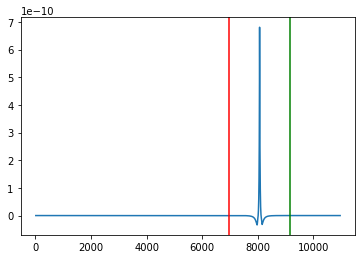

In [12]:
plt.plot(chis, [integrand(chib, (chimin+chimax)/2, 13) for chib in chis])
plt.axvline(chimin, c='r')
plt.axvline(chimax, c='g')

In [13]:
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), nbins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [14]:
from scipy.integrate import quad_vec, dblquad, nquad


In [18]:
options={'limit':11234567, 'epsabs':0.0, 'epsrel':1e-3}
def compute_bin_element(params):
    i,l,r,ell_idx = params
    res, _ = nquad(integrand, [[10, chimax_sample], #chib
                            [l, r]], #chi
                opts=[options,options],
                args=(ell_idx,))
    res /= dchi_binned
    return (ell_idx, i, res)

In [19]:
params_list = []
for ell_idx in range(len(ells)):
    for i in range(nbins):
        l, r = chi_bin_edges[i], chi_bin_edges[i+1]
        params = (i, l, r, ell_idx)
        params_list.append(params)

In [20]:
compute_bin_element(params_list[0])

(0, 0, 3.6057035946420324e-08)

In [21]:
with Pool(processes=32) as pool:
        results = list(tqdm(
            pool.imap(compute_bin_element, params_list),
            total=len(params_list)
        ))

  5%|▍         | 469/10000 [04:47<1:37:16,  1.63it/s]/home/users/delon/.local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
 10%|▉         | 979/10000 [07:25<41:52,  3.59it/s]  /home/users/delon/.local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
 11%|█▏        | 1131/10000 [08:22<50:46,  2.91it/s]  /home/users/delon/.local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
 13%|█▎        | 1284/10000 [09:03<32:19,  4.49it/s]  /home/users/delon/.local/lib/python3.9/site-packages/scipy/integra

 74%|███████▍  | 7426/10000 [29:29<11:50,  3.62it/s]/home/users/delon/.local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
 76%|███████▌  | 7569/10000 [29:52<07:45,  5.22it/s]/home/users/delon/.local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/users/delon/.local/lib/python3.9/sit

 80%|████████  | 8017/10000 [32:38<13:11,  2.51it/s]/home/users/delon/.local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/users/delon/.local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/users/delon/.local/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the 

KeyboardInterrupt: 

In [ ]:
I_kappa = np.zeros((len(ells), nbins), dtype = np.float64)
for ell_idx, i, res in results:
    I_kappa[ell_idx, i] = res

In [ ]:
np.max(np.abs(I_kappa))

In [ ]:
np.save(oup_fname, I_kappa)

In [ ]:
plt.figure(dpi = 300, facecolor = 'w')
for Lambda_idx in range(25):
    if(Lambda_idx % 6 != 0):
        continue
    ILo_kappa = np.zeros((100, nbins))

    for curr_bin in range(nbins):
        oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/ILok_'
        oup_fname+= 'zmin_%.5f_zmax_%.5f_idx_%d_dblquad_n_bins_%d_curr_%d.npy'%(zmin, zmax, 
                                                                                Lambda_idx, 
                                                                                nbins, 
                                                                                curr_bin)
        ILo_kappa[:,curr_bin] = np.load(oup_fname)


    IHi_kappa = I_kappa - ILo_kappa

    plt.plot(chi_bin_centers, IHi_kappa[42], label = 'Lambda = %.1e'%(Lambdas[Lambda_idx]))
    plt.legend(frameon= False)
    plt.xlim(chimin, chimin + 1000)
    plt.xlabel('chi')
    plt.ylabel('IHi Kappa ell = 140')
